In [ ]:
!pip install torch torchvision matplotlib numpy

Epoch [0/30] | D Loss: 0.6287 | G Loss: 0.6495


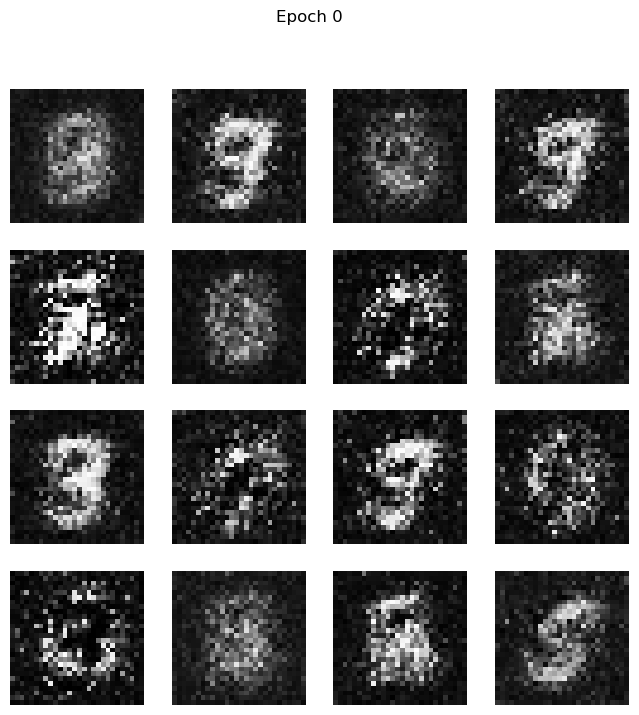

Epoch [5/30] | D Loss: 0.6531 | G Loss: 0.8359


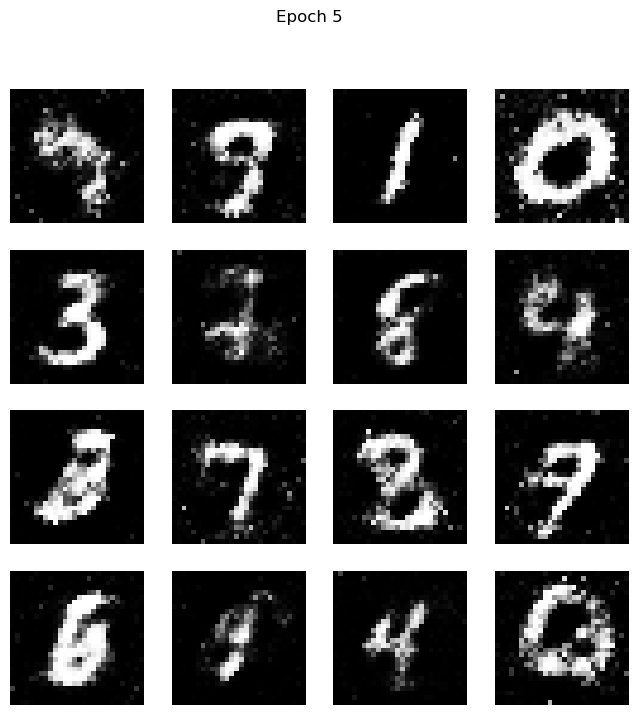

Epoch [10/30] | D Loss: 0.6466 | G Loss: 0.7714


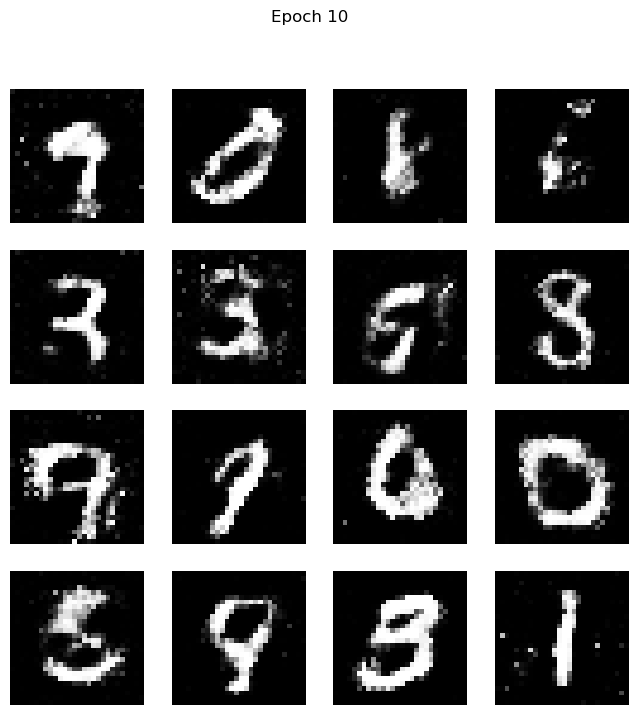

Epoch [15/30] | D Loss: 0.6520 | G Loss: 0.7931


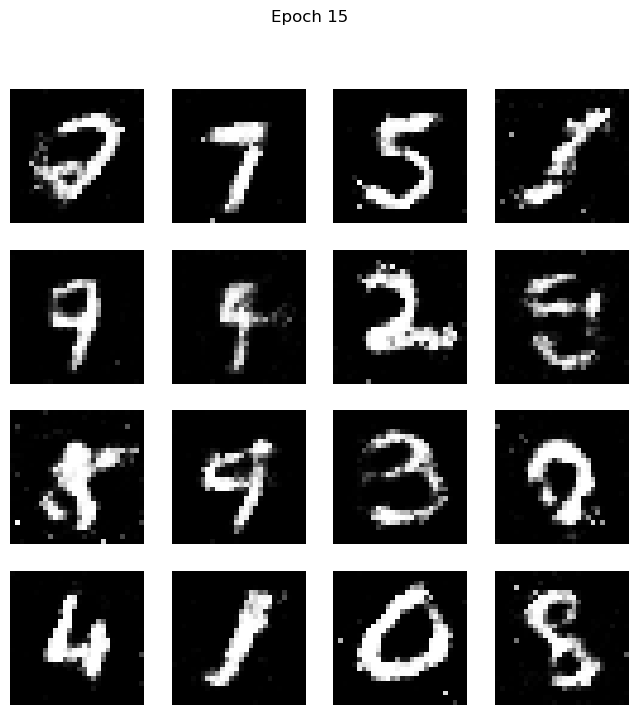

Epoch [20/30] | D Loss: 0.6488 | G Loss: 1.0145


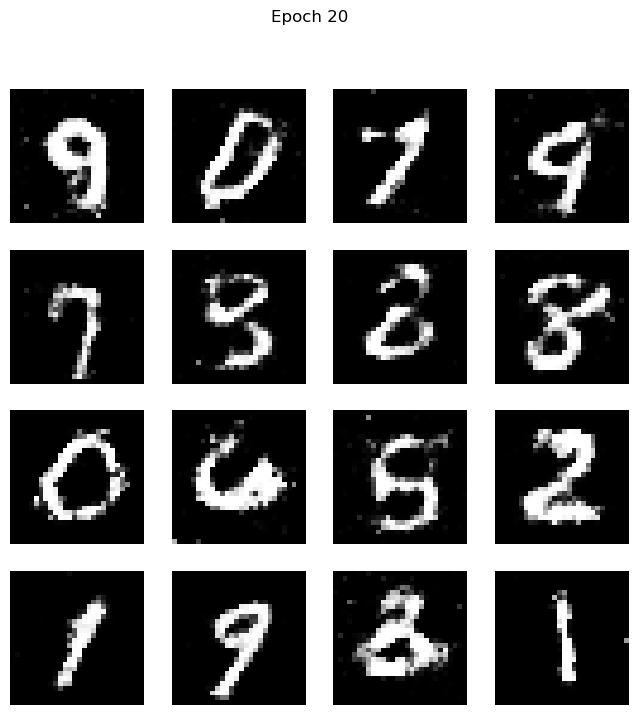

Epoch [25/30] | D Loss: 0.6556 | G Loss: 0.6840


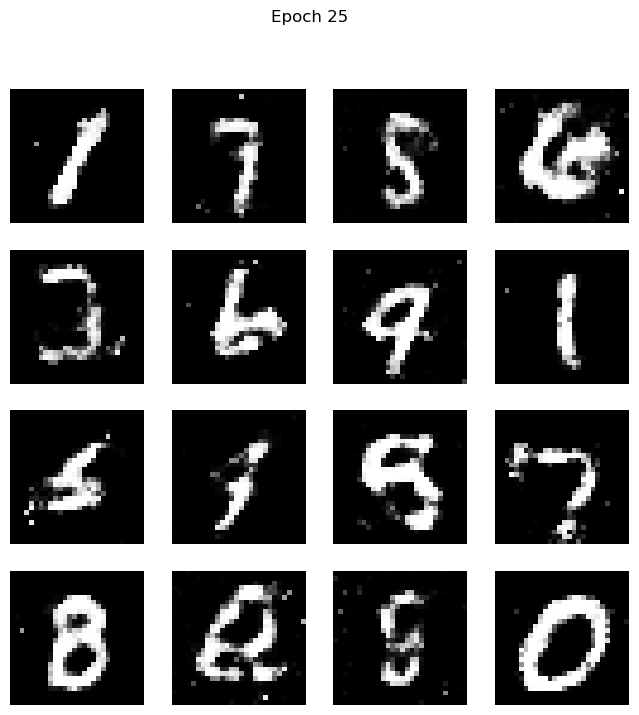

Epoch [29/30] | D Loss: 0.6538 | G Loss: 0.8494


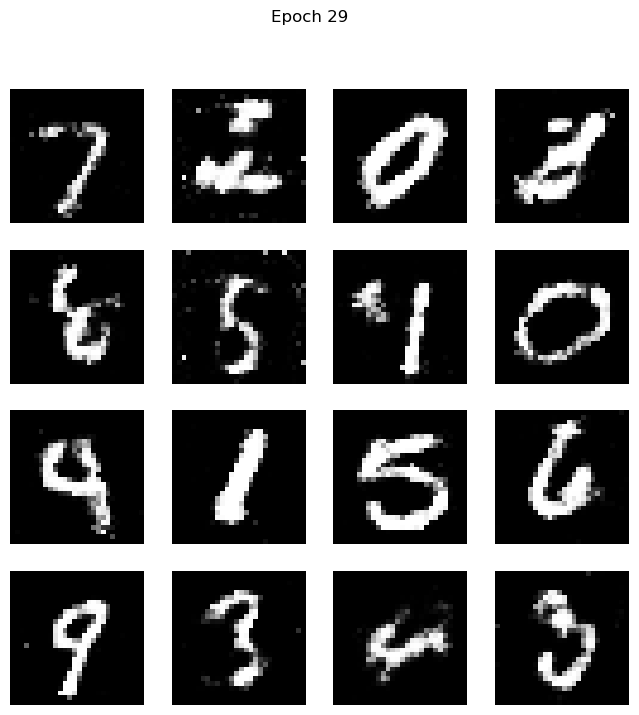

Training complete! Models saved.


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ===== FASTER CONFIGURATION =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
image_size = 28 * 28
batch_size = 128  # Increased from 64 (faster but needs more VRAM)
epochs = 30       # Reduced from 50 (still gets decent results)

# ===== MODELS (UNCHANGED) =====
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img.view(-1, image_size))

# ===== FASTER DATA LOADING =====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,  # Parallel data loading
    pin_memory=True if device.type == 'cuda' else False
)

# ===== INITIALIZATION =====
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
loss_function = nn.BCELoss()

# ===== OPTIMIZED TRAINING LOOP =====
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        current_batch = real_imgs.size(0)
        
        # Adversarial labels
        real_labels = torch.ones(current_batch, 1, device=device)
        fake_labels = torch.zeros(current_batch, 1, device=device)
        
        # --- Train Discriminator ---
        optimizer_D.zero_grad(set_to_none=True)  # Faster memory clearing
        
        # Real images
        real_preds = discriminator(real_imgs)
        real_loss = loss_function(real_preds, real_labels)
        
        # Fake images
        noise = torch.randn(current_batch, latent_dim, device=device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = loss_function(fake_preds, fake_labels)
        
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # --- Train Generator ---
        optimizer_G.zero_grad(set_to_none=True)
        g_loss = loss_function(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()
    
    # Show progress every 5 epochs instead of 10
    if epoch % 5 == 0 or epoch == epochs - 1:
        print(f"Epoch [{epoch}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        
        with torch.no_grad():
            test_noise = torch.randn(16, latent_dim, device=device)
            generated = generator(test_noise).cpu()
            
            fig, axs = plt.subplots(4, 4, figsize=(8, 8))
            for i, ax in enumerate(axs.flat):
                ax.imshow(generated[i, 0], cmap='gray', vmin=-1, vmax=1)
                ax.axis('off')
            plt.suptitle(f"Epoch {epoch}")
            plt.show()

# Save final models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
print("Training complete! Models saved.")

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ===== FASTER CONFIGURATION =====
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100  # Dimension of the random noise vector (generator input)
image_size = 28 * 28  # MNIST images are 28x28 pixels (flattened to 784)
batch_size = 128  # Increased from 64 for faster training (requires more VRAM)
epochs = 30       # Reduced from 50 while still maintaining decent results

# ===== MODELS (UNCHANGED) =====
class Generator(nn.Module):
    """Generator network that creates images from random noise"""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Fully connected network that gradually upsamples the noise vector
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),  # LeakyReLU helps with gradient flow
            nn.BatchNorm1d(256),  # BatchNorm stabilizes training
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            
            nn.Linear(1024, image_size),  # Output layer - size of MNIST image
            nn.Tanh()  # Tanh outputs values between -1 and 1 (matches normalized input)
        )
    
    def forward(self, z):
        # Generate image and reshape to (batch, channel, height, width)
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    """Discriminator network that classifies images as real or fake"""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Fully connected network that downsamples the image
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 1),  # Single output (real/fake probability)
            nn.Sigmoid()  # Sigmoid converts to probability [0,1]
        )
    
    def forward(self, img):
        # Flatten image and pass through discriminator
        return self.model(img.view(-1, image_size))

# ===== FASTER DATA LOADING =====
# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Load MNIST dataset
train_data = datasets.MNIST(
    root='./data',  # Directory to store data
    train=True,     # Use training set
    download=True,  # Download if not available
    transform=transform
)

# Create data loader with optimizations
dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,    # Shuffle data each epoch
    num_workers=2,   # Parallel data loading (speeds up data loading)
    pin_memory=True if device.type == 'cuda' else False  # Faster data transfer to GPU
)

# ===== INITIALIZATION =====
# Create and move models to appropriate device (GPU/CPU)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Use Adam optimizers with parameters from DCGAN paper
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Binary Cross Entropy loss for the discriminator's classification task
loss_function = nn.BCELoss()

# ===== OPTIMIZED TRAINING LOOP =====
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):  # _ ignores the labels
        real_imgs = real_imgs.to(device)
        current_batch = real_imgs.size(0)  # Get current batch size (may vary at end)
        
        # Create labels (1 for real, 0 for fake)
        real_labels = torch.ones(current_batch, 1, device=device)
        fake_labels = torch.zeros(current_batch, 1, device=device)
        
        # --- Train Discriminator ---
        optimizer_D.zero_grad(set_to_none=True)  # Faster memory clearing than default
        
        # Train with real images
        real_preds = discriminator(real_imgs)
        real_loss = loss_function(real_preds, real_labels)
        
        # Train with fake images
        noise = torch.randn(current_batch, latent_dim, device=device)  # Generate noise
        fake_imgs = generator(noise)  # Generate fake images
        fake_preds = discriminator(fake_imgs.detach())  # Detach to avoid training generator here
        fake_loss = loss_function(fake_preds, fake_labels)
        
        # Combined discriminator loss (average of real and fake losses)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()  # Backpropagate
        optimizer_D.step()  # Update discriminator weights
        
        # --- Train Generator ---
        optimizer_G.zero_grad(set_to_none=True)
        # Generator wants discriminator to think fakes are real
        g_loss = loss_function(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()
    
    # Show progress every 5 epochs and at the end
    if epoch % 5 == 0 or epoch == epochs - 1:
        print(f"Epoch [{epoch}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        
        # Generate sample images to visualize progress
        with torch.no_grad():  # No need to track gradients here
            test_noise = torch.randn(16, latent_dim, device=device)  # Fixed noise for consistent samples
            generated = generator(test_noise).cpu()  # Move to CPU for plotting
            
            # Create 4x4 grid of generated images
            fig, axs = plt.subplots(4, 4, figsize=(8, 8))
            for i, ax in enumerate(axs.flat):
                ax.imshow(generated[i, 0], cmap='gray', vmin=-1, vmax=1)
                ax.axis('off')
            plt.suptitle(f"Epoch {epoch}")
            plt.show()

# Save final models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
print("Training complete! Models saved.")